In [4]:
%matplotlib inline

In [5]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d

import skimage
import skimage.io
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Principle Component Analysis

## Intuitions
### Dataset

There are some prerequsites neccessary to understand how Principle Component Analysis (PCA) works. Let's describe the main concepts and get some intuitions. A full understanding of all related topic is too difficult and is outside the scope of this project.

PCA is applyed on data. However, the data format or way it is arranged is not random: data is represesnted as a dataset.

A **DATASET** is collection of data arranged in a 2D table (matrix). It has **ROWS** and **COLUMNS**. Each row is a single measurement (called **RECORD**) and each column holds one characteristic (called **VARIABLE**).

Let's look at an example: a dataset containing measurements of Italian wines. Full description is in this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.index). Some parts of the description are quoted below to make you aware of the main contex:

> These data are the results of a chemical analysis of
> wines grown in the same region in Italy but derived from three
> different cultivars.
> The analysis determined the quantities of 13 constituents
> found in each of the three types of wines. 

The variables include both substances such as alcohol, ash, and magnesium and properties of the wine - color intensity and hye. Each record is a measurement of a single bottle of wine. As described above, variables are in the dataset columns, records - in the rows. Rach row has a name or id, the set of all names or ids is called **INDEX**. Each column also contains the name of the variable, all names are called **HEADER**.

It is critical to know how data is formatted and what the various terms mean to comprehend PCA. Be aware there are multiple words for the same thing (expecially useful to make sense of reading aricles online):
* record is also called entry
* variable is also called feature

There is one final column we have not discussed yet - the target. To understand its meaning, it is helpful to first discuss the notion of predictive analysis.

**PREDICTIVE ANALYSIS** is the action of using data and algorithms to calculate likelyhood of future outcomes based on historycal data.

The **target** is a column with the outcomes we try to predict.

In the example above, the first column contains the variety of wine. The name is however not included as text, but is rather **encoded** that is represented as a number. In our dataset there are 3 unique numbers: 0, 1 and 2. Unfortunatelly, our dataset description does not specify the variety; let's assume the varieties are Chardone, Merlot, Cabernet Franc. 

The target is also called response or output. That is because the purpose of the predictive analysis is, not surprisingly, to predict the wine variety based on its characteristics. The terms below make sense in this contex:
* feature = column in the dataset = **input**
* target = column in the dataset = **output** = **response**

Data is modified well using Linear Algebra. In this context, each feature is viewed as a dimension or axis; record is viewed as a vector with components (coordinates) in those axes. We say the vectors are in space $R^n$ where $n$ is the number of dimensions. In the wine example, there are 172 vectors in space $R^13$. Thus each vector (meaning each wine) has 13 dimensions (wine characteristics).
* feature = **dimension**
* target = **vector**

After the detailed review above, let's open the data set and play with it a bit. You can also notice that the features are also encoded.

In [11]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


This pictures shows the main terms.
<div>
    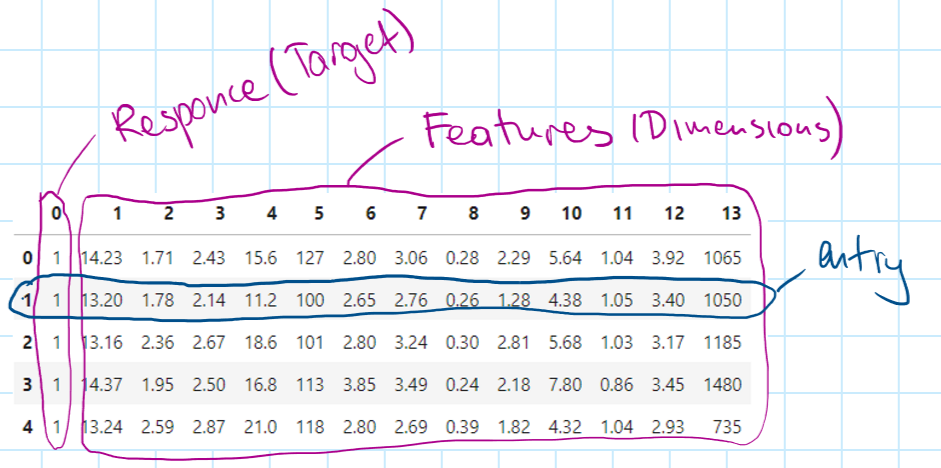
</div>

### Too many features

Having large number of columns (features, inputs) is a problem TODO list problems.

The simplest options to reducte the number of features is the just to remove columns that is select only those with the most impact. This is called **feature selection**.

PCA is better. The main idea is the same: compress the dataset (it is also correct to say "to reduce the number of dimensions"). However, before doing selection, we first construct new features from the old ones. The new are a combination of the old ones. Why do we bother though? Because the new features (with the help of linear algebra) are such that describe (or fit) the data better.

### Normalization

= Centering + Scaling

Values are in various scales as the objects or phenomenon we are measuring are also various. Thus, data often is normalized - meaning 

Z-score.

### Eigenvalues and eigenvectors

Lets look a following 2D example. Let $A$ be a random 2x2 matrix, for example the one defined below. If we multipy a vector $\vec x = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ by $A$ (or any vector for that matter), the vector will be sent to a "new place" in the xy plane. Technically speaking, we are treating $A$ as a matrix of a linear tranformation:
$$ A \vec x = \vec b $$

In [269]:
def plot_radius_vectors(vectors, colors, move_origin=False):
    """
    Plots 2D radius vectors on the xy-plane. Each vector is in the format (end_x, end_y).
    """
    # Extract vector coordinates
    flattened = np.array(vectors).ravel()
    end_x, end_y = flattened[::2], flattened[1::2] 

    # Plot an arrow
    start_x = np.zeros(end_x.shape)
    start_y = np.zeros(end_x.shape)
    plt.quiver(start_x, start_y, end_x, end_y, scale=1, scale_units='xy', angles = "xy", color=colors)

    # Make the plot pretty (housekeeping)
    all_x = np.concatenate((start_x, end_x))
    all_y = np.concatenate((start_y, end_y))
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    correction = 1
    plt.xlim(min_x - correction, max_x + correction)
    plt.ylim(min_y - correction, max_y + correction)
    
    
    # Move origin
    ax = plt.gca()
    if move_origin:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

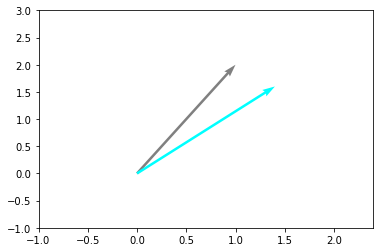

In [27]:
A = np.array([
    [0.8, 0.3],
    [0.2, 0.7],
])

x = np.array([1, 2])
b = A @ x
plot_radius_vectors([x, b], colors=['gray', 'aqua'])

It is clear the new vector $ \vec b $ has "moved". We can further transform $ \vec b $ to see the outcome: 

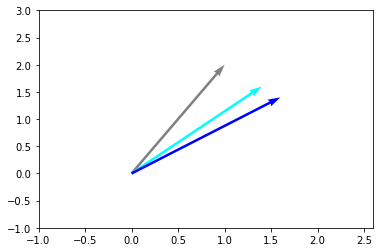

In [28]:
plot_radius_vectors([x, b, A @ b], colors=['gray', 'aqua', 'blue'])

Let's try another vector: $\vec x = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$:

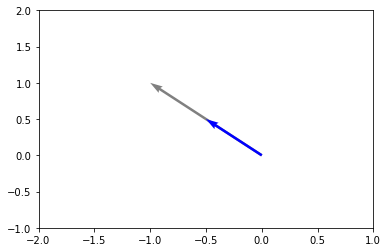

In [29]:
x = np.array([-1, 1])
b = A @ x
plot_radius_vectors([x, b], ['gray', 'blue'])

Well, that is interesting, the two vectors seem to lie on the same line. Is this a coincidence? Acutually not - I chose  $ \begin{bmatrix} -1 \\ 1 \end{bmatrix}$ on purpose, I knew what would happen in advance. Let's compare the distances of the two vectors.

In [30]:
x_len = np.sqrt(x @ x)
b_len = np.sqrt(b @ b)
b_len / x_len

0.49999999999999994

It seems to have shrunk in half (assuming there is some calculation error). Here comes a sensible question: are there more "special" vectors with the same behavior? Also, how can those be calculated? Let's write the transformation from above:
$$ A \vec x = \vec b = \lambda x$$

Projection

Projection of a vector on another vector can be viewed from different prospectives. The most intuitive way is the geometrical. From the prospective of the linear algebra, projection is a transformation, linear operator in particular. As every other transformation, the projection has a matrix. Multiplying this matrix over any vector causes it to "move" to a new location. As we are using the same recepient vector, the projection basically compresses the 2D space to a line (in the 2D case).

Consider the example below. We will be projecting the RED vector $\vec a$ over the GRAY $\vec b$. Projection matrix has a rank: rank 1.

The projection matrix is:
$$ P = a  TODO$$

In [270]:
def visualize_transformation(matrix, plot_title):
    """
    Visualize the 2D linear transformation with transformation `matrix`.
    Plots the current (before) and newgrid (after the transformation).
    """
    # Create new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.axis("equal")
    
    # Modify tranformation matrix to work with Affine2D
    modified = np.concatenate((matrix, np.zeros((2,1))), axis = 1)
    modified = np.concatenate((modified, [[0, 0, 1]]),axis=0)
    
    # Current unit vectors and grid
    ax.quiver([0, 0], [0, 0], [1, 0], [0, 1], color = ["red", "blue"], alpha = 0.2, units = "xy", scale = 1)
    ax.grid()
    
    # Transform the space
    t = Affine2D(modified)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    [min_x, max_x, min_y, max_y] = [2 * ax.get_xlim()[0], 2 * ax.get_xlim()[1] + 1, 2 * ax.get_ylim()[0], 2 * ax.get_ylim()[1] + 1]
    
    # New grid lines
    # Horizontal
    for y in np.arange(min_y, max_y):
        ax.plot([min_x, max_x], [y] * 2, color = "red", linestyle = "--", linewidth = 2, transform = t + ax.transData)
    # Vertical
    for x in np.arange(min_x, max_x):
        ax.plot([x] * 2, [min_y, max_y], color = "blue", linestyle = "--", linewidth = 2, transform = t + ax.transData)

    # New unit vectors
    new_x = t.transform_affine([1, 0])
    new_y = t.transform_affine([0, 1])
    ax.quiver([0, 0], [0, 0], [new_x[0], new_y[0]], [new_x[1], new_y[1]], color = ["red", "blue"], units = "xy", angles = "xy", scale = 1)
    
    # Make the plot pretty (housekeeping)
    ax.set_xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1] + 1))
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])  
    ax.set_title(plot_title)

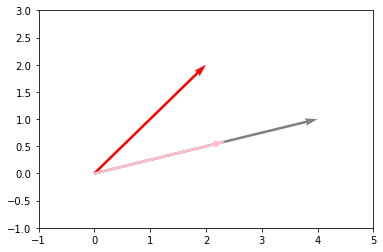

In [271]:
a = np.array([
    [4],
    [1],
])
b = np.array([
    [2],
    [2],
])


def calc_projection(a):
    """
    Returns the projection matrix to project on vector `a`.
    """
    return (a @ a.T) / (a.T @ a)

# Projection matrix (rank 1)
P = calc_projection(a)
b_projection = P @ b
plot_radius_vectors([a, b, b_projection], ['grey', 'red', 'pink'])
plt.show()

The projection matrix projects any vector $b$ onto the line $a$ is lying on. Basically, the 2d space is compressed in a single line (from 2 to 1 dim).

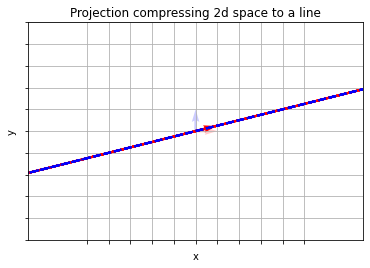

In [272]:
visualize_transformation(P, "Projection compressing 2d space to a line")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Note:** The selection of $\vec{a}$ is not affecting the projection $\vec{p}$. This makes sense as $\vec{a}$ was chosen at random and also because the projection is on the **line** that $\vec{a}$ lies on.

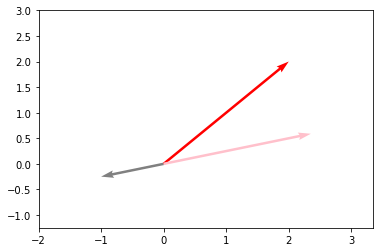

In [33]:
a = np.array([
    [-1],
    [-0.25],
])
P = ((a @ a.T) / (a.T @ a))
p = P @ b
plot_radius_vectors([a, b, p], ['grey', 'red', 'pink'])

### Matrix Factorization

To **factorize** or **decompose** a matrix is the action of representing it as a product of several matrices. The corresponding processes are unsurprisingly called matrix factorization and matrix decomposition.

Matrix **diagonalization** is a specific case of factorization. While factorization allow any matrixes in the product, diagolizing $A$ has to result in the following specific type: $A=PDP^{-1}$. If $A$ can be diagonalized, it is called diagonalizable. Only square $A$ can be diagonalized.

The diagram below shows some factorizations. As PCA is based on the singlular value decomposition (SVD), the latter is highlighted in purple.

<div>
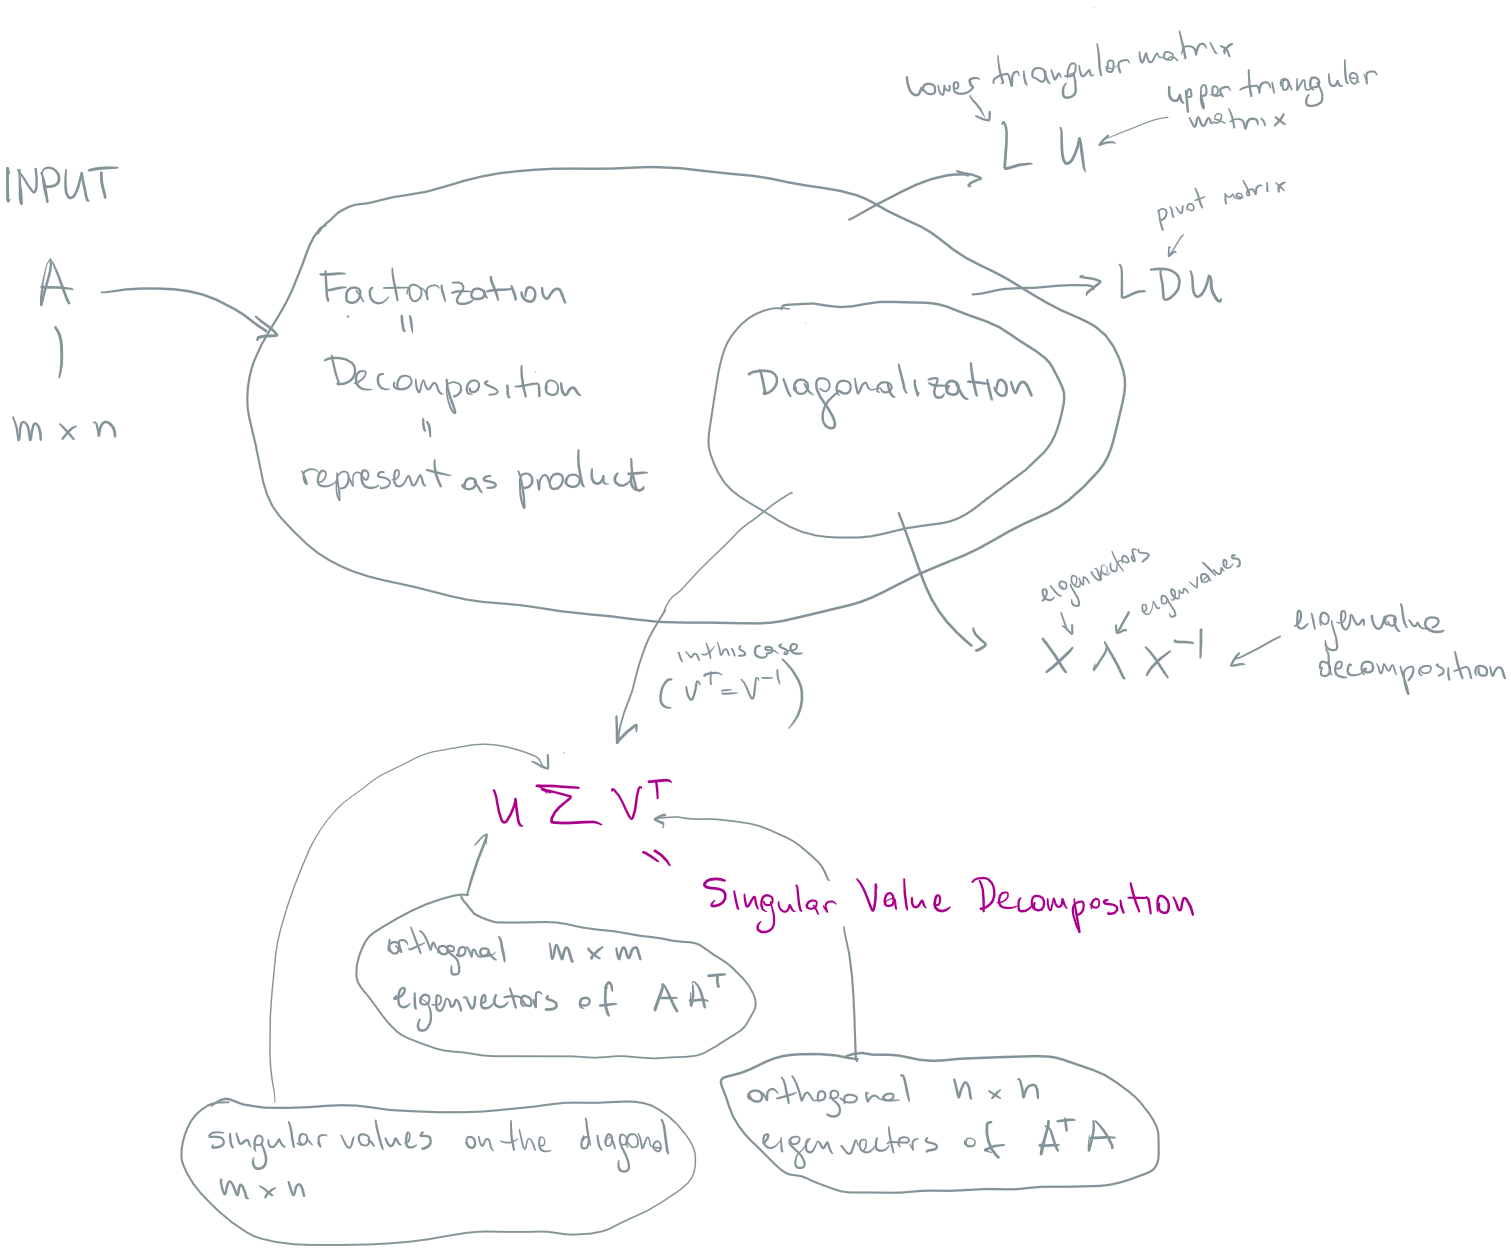
</div>

### Singular Values Decomposition (SVD)

**Singular Values Decomposition (SVD) is type of matrix factorization** of the type $ A = U \Sigma V^T $. Lets see  what does each of those three matrixes contain.


$$ A = U \Sigma V^T $$

$$ 
A_{m_\text{x}n}=
\begin{bmatrix}
    \vdots & &\vdots \\
    \vec{u_1} &\dots & \vec{u_m}\\
    \vdots & & \vdots \\
\end{bmatrix}
\begin{bmatrix} 
    \sigma_{1} & &\\ 
    & \ddots &\\ 
    & & \sigma_{n}\\
 \end{bmatrix} 
\begin{bmatrix} 
    \dots \vec{{v}_1}^T \dots \\
    \vdots\\
    \dots \vec{{v}_n}^T \dots \\ 
 \end{bmatrix} 
$$

Good explanation of SVD can be found [here](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491).

For a matrix $A_{m_\text{x}n}$ ($m$ rows and $n$ columns), SVD produces two orthonormal bases: $ \vec{u_1}, \vec{u_2},\dots \vec{u_m} $ and $ \vec{v_1}, \vec{v_2},\dots \vec{v_n}$.
The $\vec{u_i}$ are the eigenvectors of $AA^T$ and $\vec{v_i}$ are the eigenvectors of $A^TA$. Those bases vectors are combined to form the *columns* of $U_{m_\text{x}m}$ and $V_{n_\text{x}n}$. Note that both $U$ and $V$ are square, each "taking" one of the dimensions of $A$.

$\Sigma$ is a diagonal matrix with the squared eigenvalues of $AA^T$ (or $A^TA$, they are the same): $\sigma_i=\sqrt{\lambda_i}$. $\sigma_i$ are called **singular values**, that is where the "singlular" in SVD comes from. The basis vectors in the columns of $U$ and $V$ are called **singular vectors** respectively.

We can also interpret SVD as *linear transformation*: tranformation matrix $A$ acts on vector $\vec{v}_i$ converting it to $ \sigma_i \vec{u}_i $ (=scaled version of $ \vec{u}_i $):
$$ A V = U \Sigma$$
$$ A \vec{v}_i = \sigma_i \vec{u}_i $$

Finally, it is also convinient to think of SVD as the *sum of the basis vectors* of $U$ and $V$. In this form, the first terms carry the most "weight" as the $\sigma$'s are in descending order (largest first). More about this - later in PCA.
$$ A = \sigma_1 \vec{u_1} {\vec{v_1}}^T + \sigma_2 \vec{u_2} {\vec{v_2}}^T+ \dots + \sigma_r \vec{u_r} {\vec{v_r}}^T $$

To illustrate SVD, lets decompose a simple 2x2 matrix. The algorithm is:

1) Define matrix $A$.
2) Find $AA^T$. Find its eigen vectors and eigen values, group them in pairs.
3) Sort those pairs in descending order for the eigen values.
4) Create $U$ by putting the $AA^T$ eigen vectors in the columns.
5) Similarly, find $A^TA$ and form $V$ with columns the sorted eigen vectors.
6) Create diagonal matrix $\Sigma$ by placing the singular values (=squares of the eigen values of $A^TA$ or $AA^T$) in the main diagonal.
7) Finally, find $ U \Sigma V^T $.
8) To verify the result (= to test), we compare the matrixes with the output of the numpy buildin function `np.linalg.svd()`. We expect the two results to match. Also, we compare the end product $ U \Sigma V^T $ to the initial matrix $A$.

Be aware of the following risk when using a custom algorithm: the SVD product $ U \Sigma V^T $ may not be equal to $A$ because an eigen vector is in the opposite direction ($(-x, -y)$ instead of $(x, y)$). It took me quite some time to figure this out. More info [here](https://stackoverflow.com/questions/17998228/sign-of-eigenvectors-change-depending-on-specification-of-the-symmetric-argument).
Such eigen vector is still valid as it remains orthogonal with the other one. However, the final result $A = U \Sigma V^{-1}$ may not match the initial matrix $A$.

In [87]:
A = np.array([
    [3, 0],
    [4, 5],
])

def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

def calculate_svd_matrixes(A):
    """
    Returns the matrixes (U, Sigma, V) of the singular value decomposition of A. 
    """
    # Calculate matrix U
    product = A @ A.T
    eigvalues, eigvectors = np.linalg.eig(product)
    eigvalues , U = sort_eigen(eigvalues, eigvectors)

    # Calculate matrix V
    product = A.T @ A
    eigvalues, eigvectors = np.linalg.eig(product)
    _, V = sort_eigen(*np.linalg.eig(A.T @ A))

    # Calculate the sigma matrix
    S = np.diag([np.sqrt(e) for e in eigvalues])

    return U, S, V

# Tests
# My SVD script
U, S, V = calculate_svd_matrixes(A)
U[:,0] *= -1  # inverting the signes of the first column
SVD = U @ S @ V.T

# Numpy build-in SVD
u, s, v = np.linalg.svd(A, full_matrices=True)
s = np.diag(s)
svd = u @ s @ v.T

print(f"""
TEST 1: Verify the results match numpy.linalg.svd().

U
My script:
{U}
Numpy:
{u}\n

V
My script:
{V}
Numpy:
{v}

Sigma
My script:
{S}
Numpy:
{s}
""")

print(f"""
TEST #2: Validate multiplying the resultant matrixes produces the original matrix.\n
Original matrix A:
{A}
SVD, my script:
{SVD}
SVD, numpy:
{svd}
""")


TEST 1: Verify the results match numpy.linalg.svd().

U
My script:
[[ 0.31622777 -0.9486833 ]
 [ 0.9486833   0.31622777]]
Numpy:
[[-0.31622777 -0.9486833 ]
 [-0.9486833   0.31622777]]


V
My script:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Numpy:
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Sigma
My script:
[[6.70820393 0.        ]
 [0.         2.23606798]]
Numpy:
[[6.70820393 0.        ]
 [0.         2.23606798]]


TEST #2: Validate multiplying the resultant matrixes produces the original matrix.

Original matrix A:
[[3 0]
 [4 5]]
SVD, my script:
[[ 3.00000000e+00 -6.66133815e-16]
 [ 4.00000000e+00  5.00000000e+00]]
SVD, numpy:
[[3.00000000e+00 1.33226763e-15]
 [4.00000000e+00 5.00000000e+00]]



Observations:
* The custom script $\vec{{u}_1}$ (that is the first column in $U$) is numpy's $(-1)\vec{{u}_1}$.
* Both final results are equal to the original matrix $A$.

In summary, we managed to decompose (that is represent as product of several matrixes) a random non-symmetric matrix.

## PCA
### Introduction
Data coming from experiments or observations is often stored in matrixes. Most times (practically: always), data is in the shape of a set of measurements of individual *samples*, where a set of *charactereristics* are measured for every single sample. For example, dimensions (=characteristics) are measured for metal parts (=samples). Another example: survey results (=characteristics) of interviews with random people (=samples).

Lets look at **some examples** to understand why PCA is useful.
[Example 1:](https://learnopencv.com/principal-component-analysis/) Imagine you conducted a survey with 20 questions. Using PCA, you might find that only by knowing the political affinity of the person his answers to the other questions are highly probable.
[Example 2:](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) Imagine you are trying to identify a wine variety. This is your final aim (note: specifying this aim is not part of the article in the link). You have available a dataset with say 30 characteristics per wine (e.g. acidity level, color depthness, bitterness...). Using PCA, we can create new characteristics e.g. 5 instead of 30, and use those instead. The new 5 characteristics will not have "nice", description meanings and names as the initial 30, because they are a *combination* calculated using mathematics.

Lets introduce the proper **therminlogy** in the context of data science and mathematics. There are multiple names for the same thing used in diffrent contexts. Characteristics are called **variables, features, or dimensions**. Samples are called **entries, records, vectors, data points, data items**.

Here, it is good to mention that there is *another strategy* alternative to generating new characteristics. We can just select a few features (in the wine example above e.g. only the color and bitterness of the wine) and use those to predict. We may take this approach if each wine variety has specific color and bitterness level and we can guess the variety based on those two paramters. From mathematical prospective, we would say there is strong correlation between those two features and the **target** that is the wine variety we try to guess (better word: predict). This approach is called **feature selection** (more info [here](https://en.wikipedia.org/wiki/Feature_selection)). Remember: PCA is not feature selection. In PCA we constuct or create new 

Finally, lets summarize the objectives of PCA:
* reduce the number of features (dimensions)

Next, lets get a feeling about PCA algorithm by solving some examples. 

### Simple Example
The first example that follows is based on [this](http://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf) article.
The data below has 2 variables (features) and 10 samples. In linear algebra prospective: 10 points in space $R^2$. 

**Important remark** follows. To use the singular value decomposition as is, each row shall be a variable and each column - a sample, data item (OPTION #1). This is the oposite of the regular, common way data is stored (e.g. in a database system) - each row is a entry and each column hold a category of values (OPTION #2). You might come across solved examples of both types, but it is good to be aware how SVD is related to PCA. I will start by solving in detail an example using OPTION #2. 



The steps in the algorithm are:
1) Get sample data (raw data). Records shall be in rows, variables - in columns (OPTION #1).
2) Center the data (name the matrix $A$). 
3) Calculate the sample covariance matrix $ S = \frac{A^TA}{n-1} $ where $n$ is the number of records (rows).
4) Calculate the eigenvalues and eigenvectors of $S$. The vectors are called **principle components**
5) Sort the eigen pairs in descending order of the values (largest first).
6) (optional) Project the data on both principle components to see a rotated veiw of the original points.
7) Project the data on the first principle component to reduce the dimensions from 2 to 1 (change space from $R^2$ to $R^1$)


Test #1
Verify sample covariance matrix S.
Expected: symmetric matrix.
Actual: 
          x         y
x  0.616556  0.615444
y  0.615444  0.716556


Test #2
Verify eigen values are sorted properly.
Expected: descending order (largest first).
Actual: 
[1.28402771 0.0490834 ]


Test #3
Visual verification that data is centered



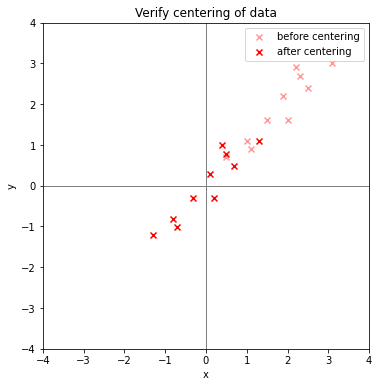

In [9]:
# Sample data
raw_data = pd.DataFrame([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3. ],
    [2.3, 2.7],
    [2. , 1.6],
    [1. , 1.1],
    [1.5, 1.6],
    [1.1, 0.9],
])
raw_data.columns = ['x', 'y']

# Center data
means = raw_data.mean()
data = raw_data - means

# Sample covariance matrix
row_num = data.shape[0]
S = data.T @ data / (row_num - 1)

# Calculate and sort eigenvalues and eigenvectors
def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

eigvalues, eigvectors = np.linalg.eig(S)
eigvalues, eigvectors = sort_eigen(eigvalues, eigvectors)
        
def format_plot(xlabel='x', ylabel='y'):
    """
    Function to group common plot formatting.
    """
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axhline(0, color='gray', linewidth=1)
    ax.axvline(0, color='gray', linewidth=1)
    plt.xlim((-4,4))
    plt.ylim((-4,4))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    
# Tests
print(f"""
Test #1
Verify sample covariance matrix S.
Expected: symmetric matrix.
Actual: \n{S}
""")

print(f"""
Test #2
Verify eigen values are sorted properly.
Expected: descending order (largest first).
Actual: \n{eigvalues}
""")

print("""
Test #3
Visual verification that data is centered
""")
plt.figure(figsize=(6, 6))
plt.scatter(raw_data.x, raw_data.y, marker='x', c='red', label='before centering', alpha=0.4)
plt.scatter(data.x, data.y, marker='x', c='red', label='after centering')
format_plot()
plt.title('Verify centering of data')
plt.legend()
plt.show()

Next, we plot the eigenvectors to see how they relate to the datapoints. As expected, the first vector is in the direction that would capature the most variance.

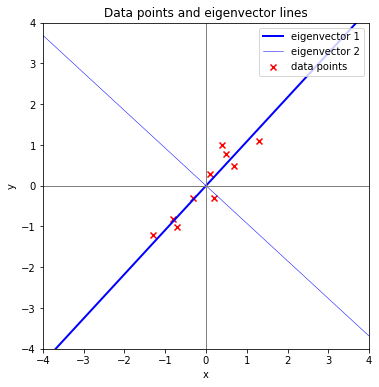

In [22]:
# Plot data points and eigenvector lines
def plot_eigvectors(eigvectors):
    """
    Plots the line where each of the eigen vector.
    """
    # for i, column in enumerate(eigvectors.T):
    #     x, y = column[0], column[1]
    #     plt.axline((0, 0), (x, y), color='b', label=f'eigenvector {i + 1}', linewidth=1)
    
    # first eigen vector
    x, y = eigvectors.T[0][0], eigvectors.T[0][1]
    plt.axline((0, 0), (x, y), color='b', label=f'eigenvector 1', linewidth=2)
    
    # second eigen vector
    x, y = eigvectors.T[1][0], eigvectors.T[1][1]
    plt.axline((0, 0), (x, y), color='b', label=f'eigenvector 2', linewidth=0.5)
        
def plot_data(data):
    """
    Simple function to plot the data. Used to abstract the algorithm in the code.
    """
    plt.scatter(data.x, data.y, marker='x', c='red', label='data points')


plt.figure(figsize=(6, 6))
plot_eigvectors(eigvectors)
plot_data(data)
format_plot()
plt.title('Data points and eigenvector lines')
plt.legend()
plt.show()

Below is the original data plotted agains the two principle components. This is simple change of the basis. However, using PCA we ensure the greatest variation of the points is captured (the spread along x axis in this case).

If you look closely you will notice that the data is flipped along the second eigenvector. This is caused by the selection of the eigen vectors, more specifically - their directions.

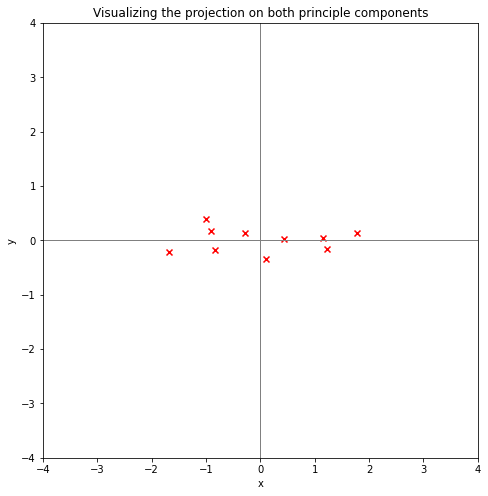

In [33]:
# Data in terms of the eigvectors
final = data @ eigvectors

# Plot the data points along the eigenvector axes
plt.figure(figsize=(8, 8))
plt.scatter(final[0], final[1], marker='x', c='red', label='data points')
format_plot()
plt.title('Visualizing the projection on both principle components')
plt.show()

Alternatively, we can project only using the first principle component and thus reduce the dimension from 2 to 1.

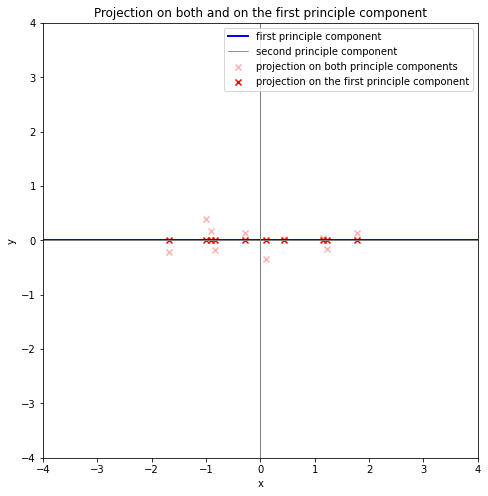

In [35]:
# Principle component
first_pc = eigvectors[:,[0]]
reduced = data @ first_pc

# Plot the result
plt.figure(figsize=(8, 8))
plt.axhline(0, color='b', label=f'first principle component', linewidth=2)
plt.axvline(0, color='b', label=f'second principle component', linewidth=0.5)

plt.scatter(final[0], final[1], marker='x', c='red', label='projection on both principle components', alpha=0.3)
plt.scatter(reduced, np.zeros(reduced.size), marker='x', c='red', label='projection on the first principle component')

format_plot()
plt.title('Projection on both and on the first principle component')
plt.legend()
plt.show()

Finally, lets plot the data before and after PCA.

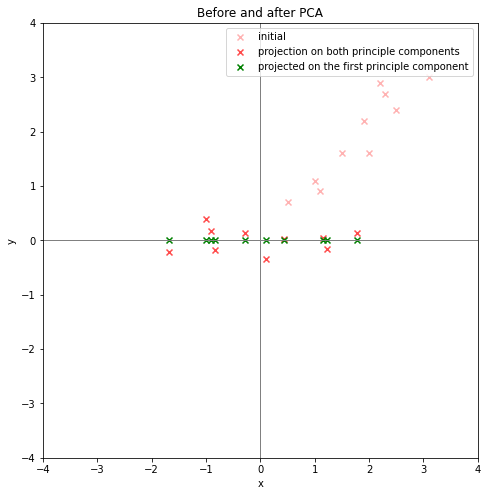

In [52]:
plt.figure(figsize=(8, 8))

plt.scatter(raw_data.x, raw_data.y, marker='x', c='red', label='initial', alpha=0.3)
plt.scatter(final[0], final[1], marker='x', c='red', label='projection on both principle components', alpha=0.7)
plt.scatter(reduced, np.zeros(reduced.size), marker='x', c='green', label='projected on the first principle component')

format_plot()
plt.title('Before and after PCA')
plt.legend()
plt.show()

### Custom Algorithm

Below is a condensed version of our custom algorithm. It is then compared to the one build in `sklearn.decomposition`.

Few words about how `sklearn.decomposition.PCA()` functions. `PCA` is a python *class* thus it gets instantiated. The new object represents the *data model* of pca. The syntax (or interface) first remined me of the pyplot *state-based* interface that `matplotlib.pyplot` uses (more on the topic [here](https://matplotlib.org/matplotblog/posts/pyplot-vs-object-oriented-interface/)).
There is one required paramter - the number of principle components the *model* shall have. To create the model we *fit* it to our data; the `fit()` *method* can be used. We can then transform (=apply PCA to any data) using another method - `transform()`. However, for demonstration purposes we want to create a PCA model and transofr the original data. Therefore, we use the `fit_transoform()` method to combine these two actions.
Full details on `sklearn.decomposition.PCA()`: [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
def calculate_svd_matrixes(A):
    """
    Returns the matrixes (U, Sigma, V) of the singular value decomposition of A. 
    """
    # Calculate matrix U
    product = A @ A.T
    eigvalues, eigvectors = np.linalg.eig(product)
    eigvalues , U = sort_eigen(eigvalues, eigvectors)

    # Calculate matrix V
    product = A.T @ A
    eigvalues, eigvectors = np.linalg.eig(product)
    _, V = sort_eigen(*np.linalg.eig(A.T @ A))

    # Calculate the sigma matrix
    S = np.diag([np.sqrt(e) for e in eigvalues])

    return U, S, V

def custom_pca(data, n):
    """
    Returns the 
    `data` shall have records in its rows, and features in its columns.
    """ 
    # Transpose and center data
    data = data.T
    data -= data.mean()

    # Sample covariance matrix
    num_records = data.shape[1]
    S = data @ data.T / (num_records - 1)

    # Calculate and sort eigenvalues and eigenvectors
    eigvalues, eigvectors = np.linalg.eig(S)
    order = eigvalues.argsort()[::-1]
    eigvalues, eigvectors = eigvalues[order], eigvectors[:, order]
    
    S = np.diag([np.sqrt(e) for e in eigvalues])

    # Project the data on the principle component axes
    P = eigvectors[:,[n]]
    reduced = np.array(data @ P)
    
    return U, S

In [24]:
def custom_pca(sample_data, num_principle_components):
    """
    Returns the 
    """
    # Center data
    means = sample_data.mean()
    data = sample_data - means

    # Sample covariance matrix
    rows_num = data.shape[0]
    S = data.T @ data / (rows_num - 1)

    # Calculate and sort eigenvalues and eigenvectors
    eigvalues, eigvectors = np.linalg.eig(S)
    order = eigvalues.argsort()[::-1]
    eigvalues, eigvectors = eigvalues[order], eigvectors[:, order]

    # Project the data on the principle component axes
    P = eigvectors[:,[num_principle_components]]
    reduced = np.array(data @ P)
    
    return reduced


Test #1
Visual comparison between custom and build-in pca algorithms.
Expected: overlapping plots.
Actual:


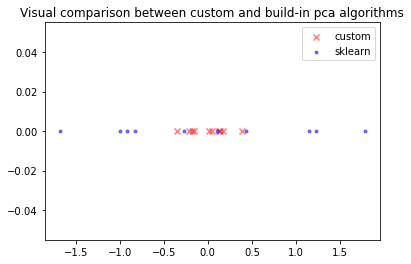


Test #2
Verify results from custom and build-in pca are equal.
Expected: differences are 0.
Actual: 
[[ 0.65285488]
 [-1.6347231 ]
 [ 1.37657248]
 [ 0.40462762]
 [ 1.46630296]
 [ 1.08823155]
 [-0.44893414]
 [-1.09815491]
 [-0.42028151]
 [-1.38649584]]



In [29]:
data = pd.DataFrame([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3. ],
    [2.3, 2.7],
    [2. , 1.6],
    [1. , 1.1],
    [1.5, 1.6],
    [1.1, 0.9],
])

# Custom function
result1 = custom_pca(data, 1)

# sklean.decomposition.PCA()
pca = decomposition.PCA(n_components=1)
result2 = pca.fit_transform(data)

# Test
print(f"""
Test #1
Visual comparison between custom and build-in pca algorithms.
Expected: overlapping plots.
Actual:""")
plt.scatter(result1, np.zeros_like(result1), marker='x', c='red', label='custom', alpha=0.5)
plt.scatter(result2, np.zeros_like(result2), marker='.', c='blue', label='sklearn', alpha=0.5)
plt.legend()
plt.title('Visual comparison between custom and build-in pca algorithms')
plt.show()

differences = result1 - result2
print(f"""
Test #2
Verify results from custom and build-in pca are equal.
Expected: differences are 0.
Actual: \n{differences}
""")

### Example: Iris flower

Let's now use the [build-in PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn. This is much easier at is abstracts PCA - we no longer care HOW the algorithm works but rather care WHAT we receive as a result. This hides the complexity and allow us to focus on applying PCA rather than understaning all the maths every time. 

Note that it is a class and not a function even though this is not immediately clear. It has parameters when instanciated, but it also has attributes (such ase `singular_values_` and `explained_variance_`) that we can call using the dot notation. Finally, there are also methods e.g. `fit()` or `fit_transform`: the first fits the model with X, the second - fits and projects (reduces the dimensions of) X.

The worked problem below is based on this  [example](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html?highlight=pca) from scikit-learn homepage.

To provide some context, below is the example description:

>This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray.
>The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [26]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [49]:
y = iris.target
y.shape

(150,)

Then we can plot the training data `X` that we will use to train the PCA model. "Traning" means to generate the vectors, the principle components, that decompose `X`. 

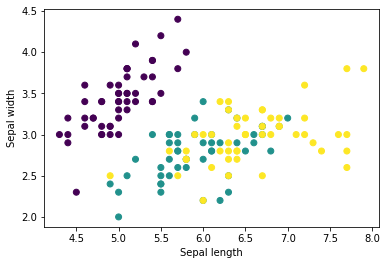

In [53]:
# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

Do not get scared by the fancy plotting parameters below - it is all to make the 3d plot below pretty. The essence of what is done is the build-in PCA class that we use:

```python
X_reduced = PCA(n_components=3).fit_transform(iris.data)
```

Also note, that the `c='y'` is not the same as `c=y`. The former one is setting one color to yellow. What we are acutally doing is assiging our target `y` defined above to the color parameter. This groups the data and gives each group a seperate color.

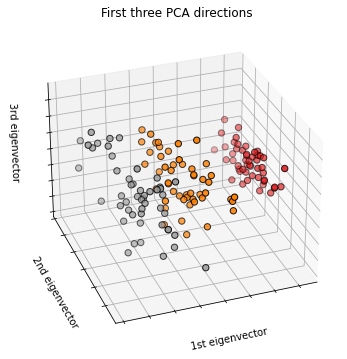

In [57]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

We can also project using the first two or just one components:

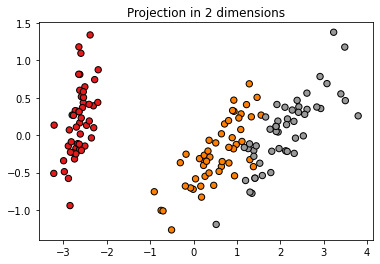

In [61]:
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
plt.title("Projection in 2 dimensions")
plt.show()

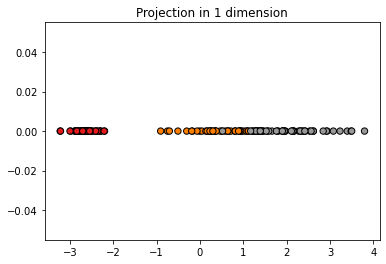

In [62]:
plt.scatter(
    X_reduced[:, 0],
    np.zeros_like(X_reduced[:, 0]),
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
plt.title("Projection in 1 dimension")
plt.show()

## Example: Wines

Lets apply PCA some more!

Imagine we are in Italy drinking wine. We are asked to guess the grape sort of the wine (we are given three options).  We are given a dataset with prior measuremen with 172 wines and 13 substances measured for each. The grape variaty (species) is also given - it is one of three sorts. The 13 substances are *Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline*.
To make such predition, we will this time 

The problem is based on [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial. 

### My adaptation

I am using [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial. However, I simplified the algorith and used more descriptive varaible names. The original version is further below. Data is freely available from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/wine).

In [22]:
# Read data
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine.shape

(178, 14)

In [19]:
data = wine.iloc[:, 1:].values
# target = wine.iloc[:, :1].values

# Normalize data
s = data.std(axis=0)
x_bar = data.mean(axis=0)
data_std = (data - x_bar) / s

# Find covariance matrix
covariance_matrix = data_std.T @ data_std

# Find eigen values and vectors
eigen_vals, eigen_vecs = np.linalg.eig(covariance_matrix)

The **total variance** is the sum of all eigenvalues (which in the PCA contex also means the sample variances). This sum is also the trace of the $\Sigma$ matrix:

$$\sigma_1^2 + \sigma_2^2 + \dots + \sigma_m^2 \text{ (eigen values)} = \text{trace of }\Sigma  = s_1^2 + s_2^2 + \dots + s_m^2 \text{ (sample covariances)}$$

In PCA we usually project the data using only the first several eigen values (or sample variances) that explain most of the data. The ratio of the used variance / total variance is called **explained variance**.

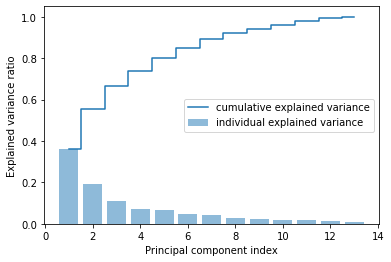

In [20]:
# Calculate cumulative sum of explained variances
total = sum(eigen_vals)
explained_var = [(value / total) for value in sorted(eigen_vals, reverse=True)]
explained_var_cum = np.cumsum(explained_var)

# Plot explained variances
plt.bar(range(1,14), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,14), explained_var_cum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend()
plt.show()

As stated before, **explained variance** is a measure of the **discrepancy** between the model and actual data. For example, if we make the model using the first 3 the first three principle components, the percentage of variation we will cover (that is the total explained variance will be ~ 66%.

In [40]:
print(f"Explained variance for the first 3 principle components:{explained_var_cum[2]}")

Explained variance for the first 3 principle components:0.6652996889318524


In [42]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Select first two princple components
pc = [
    eigen_pairs[0][1][:, np.newaxis],
    eigen_pairs[1][1][:, np.newaxis],
]
proj_matrix = np.hstack(pc)

# Test
print(f"Verifying projection matrix shape. \nExpected: (13, 2)\nActual: {proj_matrix.shape}")

Verifying projection matrix shape. 
Expected: (13, 2)
Actual: (13, 2)


`[:, np.newaxis]` is used to transform the row vector to column vector, that is to **transpose it**.

In [43]:
# Transform 
wine_pca = data_std.dot(proj_matrix)

# Test
wine_pca.shape, data_std.shape  # expected ((178, 2), (178, 13))

((178, 2), (178, 13))

Finally, we plot the transformed data. The data has now only 2 indead of 13 features (columns). It is compressed that is projected on the two new axes: principle component 1 and 2.

The target or the output is the wine sort (variaty) 

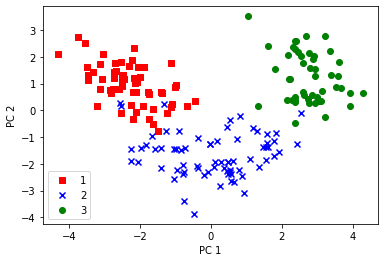

In [302]:
# Plot
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

target = wine.iloc[:, 0].values
for l, c, m in zip(np.unique(target), colors, markers):
    x = wine_pca[target==l, 0]
    y = wine_pca[target==l, 1]
    plt.scatter(x, y, c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### Original code

The original code from the article splits the data in two. **Train data** is used to generate the PCA projection matrix (=**fit the model**); it contains 124 rows. Then, the already created **model** is used to **predict** the type of wine of the remaining **train data** based on the two new features (=principle components). Of course, the train data is part of the initial dataset so we **know** the type of wine. Therefore we can compare what the model **predicts** to reality.

**Note:** since the code below uses only part of the dataset to create the model, the plots below (especially the second one - princple components) differ from my adaptation above. 

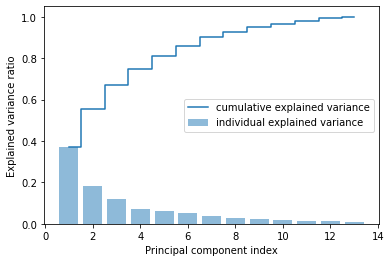

In [266]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# split into training and testing sets
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Calculate covariance matrix
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Calculate cumulative sum of explained variances
total = sum(eigen_vals)
var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [268]:
# Test to check the shapes of the test and train sets
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(124, 13)
(54, 13)
(124,)
(54,)


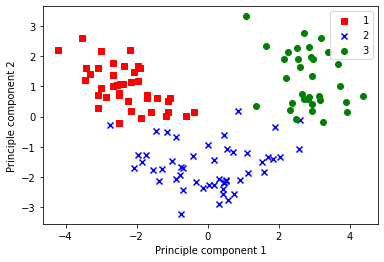

In [268]:
# Generate PCA matrix and project training data
def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

sorted_vals, sorted_vecs = sort_eigen(eigen_vals, eigen_vecs)
pca_matrix = sorted_vecs[:,:2]
X_train_pca = X_train_std.dot(pca_matrix)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')
plt.legend()
plt.show()

## Example: Eigenfaces

Eigenfaces is simply PCA applied to the face recognition problem. The raw pixel values are considered as input features. Each image is sliced into rows of pixels and the rows are arrange in order. Pixels values are first normalized (=scaled to a number between 0 and 1).

Images are freely available from [here](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces).

In [24]:
base_directory = './faces'
pattern = '**/*.pgm'

images = []
entries = pathlib.Path(base_directory).glob(pattern)
for entry in entries:
    images.append(skimage.io.imread(entry))

images = np.asarray(images)
images.shape

(400, 112, 92)

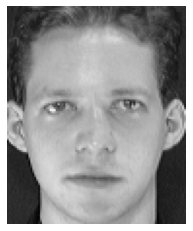

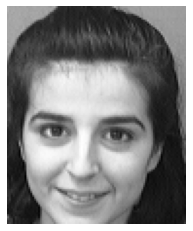

In [33]:
for img in images[:20:10,:,:]:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [36]:
# Stack images pixels in 1D columns
x, y, z = images.shape
images_hstacked = images.reshape(x, y * z)
images_hstacked.shape

(400, 10304)

In [48]:
# _, h, w = images_columns.shape
X = images_hstacked
y = np.repeat(np.arange(40), 10)
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
means = A_0.mean(axis=0, keepdims=True)
A = A_0 - means
A[:,300].mean(), A_0[:,300].mean()

(0.0, 74.0)

In [ ]:
# plt.figure(figsize=(10,60))
# plt.imshow(A_0,cmap='gray')
# plt.show()
# plt.imshow(A)

Sample covariance $S$:

In [ ]:
n = A.shape[1] # number of columns
S = A @ A.T / (n - 1)
S.shape

(40, 40)

In [ ]:
eigvalues, eigvectors = np.linalg.eig(S)
eigvalues.shape, eigvectors.shape

((40,), (40, 40))

In [ ]:
components_num = 10
components = eigvectors[:components_num]
components.shape, A.shape

((10, 40), (40, 10304))

In [ ]:
A_t = components @ A
A_t.shape

(10, 10304)

((10, 112, 92), (112, 92))

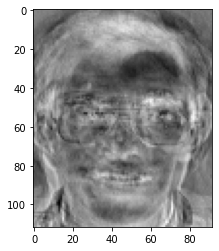

In [ ]:
final = A_t.reshape((components_num, 112, 92))
mean_face = final.mean(axis=0)
plt.imshow(mean_face, cmap='gray')

final.shape, final.mean(axis=0).shape

In [55]:
for f in final[:1]:
    plt.imshow(f, cmap='gray')
    plt.show()

NameError: name 'final' is not defined

## Appendix

### References
[MIT Linear algebra lectures](https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/video_galleries/video-lectures/)

[PCA article 1](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)

[PCA article 2](https://www.kdnuggets.com/2020/05/dimensionality-reduction-principal-component-analysis.html)

[PCA article 3](http://web.math.ucsb.edu/~atzberg/pmwiki_intranet/uploads/AtzbergerHomePage/ml_lecture_Dimension_Reduction_Atzberger.pdf)

[Good explanation of SVD](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491).

### Self-assessment
The numbers in brackets define possible points for the corresponding item.

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?

Depreciated code

In [ ]:
# # Lower resolution
# resolution = (128,96)
# rescaled = np.array([cv2.resize(img, dsize=resolution, interpolation=cv2.INTER_CUBIC) for img in images])
# plt.imshow(rescaled[0], cmap='gray')

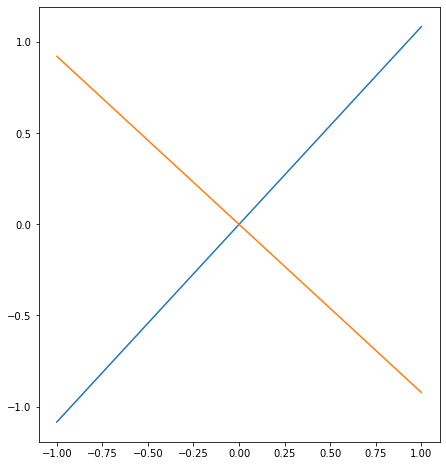

In [98]:
# def plot_functions(*funcs, x_range=(-1, 1)):
#     for f in funcs:
#         x = np.linspace(*x_range,100)
#         y = np.vectorize(f)(x)
#         plt.plot(x, y)

        
# def generate_linear_function(point1, point2):
#     x1, y1= point1
#     x2, y2= point2
#     slope = (y2 - y1) / (x2 - x1)
#     offset = y1 - slope * x1
    
#     return lambda x: slope * x + offset


# def plot_eigvectors(eigvectors):
#     plt.figure(figsize=(8,8))
#     for col_index in range(eigvectors.shape[1]):
#         origin = (0, 0)
#         eig_coords = eigvectors[0, col_index], eigvectors[1, col_index]
#         eig_line = generate_linear_function(origin_coords, eig_coords)
#         plot_functions(eig_line)
    
#     plt.gca().set_aspect('equal')
#     plt.show()
        
# plot_eigvectors(eigvectors)